# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

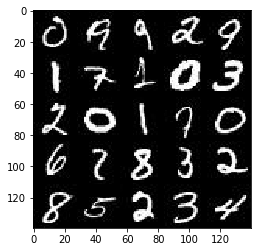

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

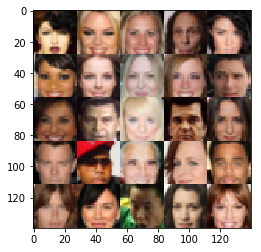

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # I will use leaky ReLU
    alpha = 0.3
    keep_probability = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 7, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_probability)
                        
        # 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 7, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)        
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_probability)
        
        # 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 7, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_probability)
        
        # 4x4x256
        x4 = tf.layers.conv2d(x3, 512, 7, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_probability)
        
        # 2x2x512
        # Flatten it        
        flat = tf.reshape(x4, [-1, 2*2*512])
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
        
    # I will use leaky ReLU
    alpha = 0.3
    keep_probability = 0.5
    
    with tf.variable_scope('generator', reuse=(not is_train)):
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x2 = tf.reshape(x1, (-1, 7, 7, 1024))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_probability)
        
        # 7x7x1024 now
        x3 = tf.layers.conv2d_transpose(x2, 512, 7, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_probability)
        
        # 7x7x512 now
        x4 = tf.layers.conv2d_transpose(x3, 256, 7, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_probability)
        
        # 14x14x256 now
        x5 = tf.layers.conv2d_transpose(x4, 128, 7, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        x5 = tf.nn.dropout(x5, keep_probability)
        
        # 14x14x128 now
        x6 = tf.layers.conv2d_transpose(x5, 64, 7, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(alpha * x6, x6)
        x6 = tf.nn.dropout(x6, keep_probability)
            
        # 28x28x64 now
        # Output layer
        logits = tf.layers.conv2d_transpose(x6, out_channel_dim, 7, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x1 or 28x28x3 now
    
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_input, z_input, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.
                # and we are using tanh (-1, 1), so...
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images})
                
                # Run g_optim twice to make sure that d_loss does not go to zero
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input:batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9109... Generator Loss: 2.9120
Epoch 1/2... Discriminator Loss: 2.2146... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 2.1904... Generator Loss: 1.2439
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 1.6926... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.8640


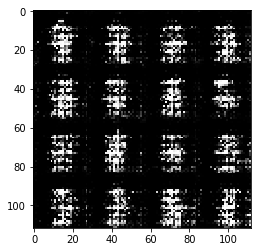

Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.9346
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.7554


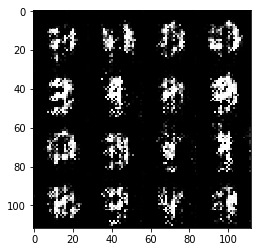

Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.8379
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.8776


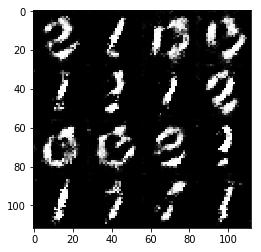

Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.7288


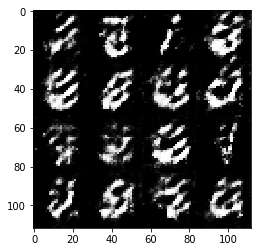

Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.6370... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.8146


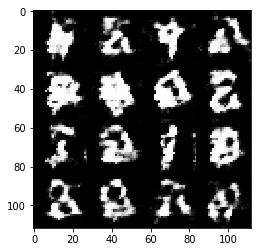

Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.7183... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.7314


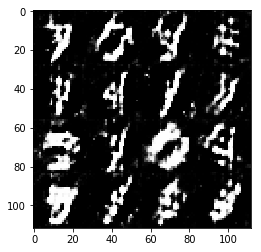

Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.8064


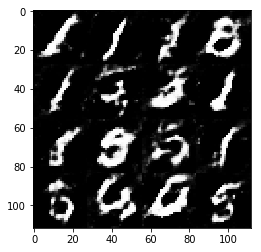

Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.5335... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.8362
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.8368


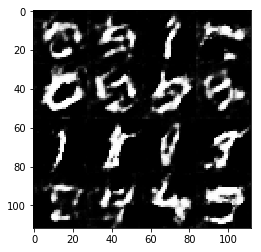

Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6695


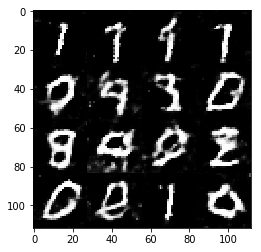

Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.0817
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.5127... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.6016


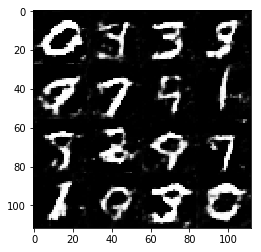

Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.7137... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.6324
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.7275


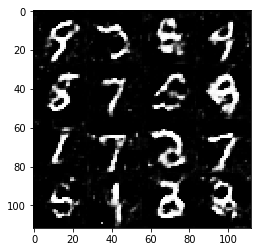

Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 1.2774


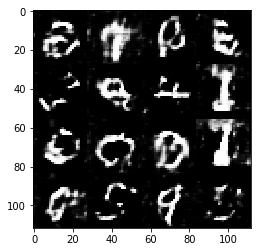

Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.5612... Generator Loss: 0.4304
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 1.0612


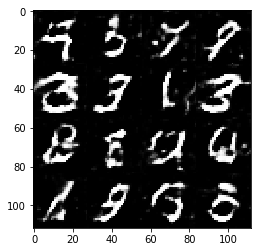

Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 0.9183


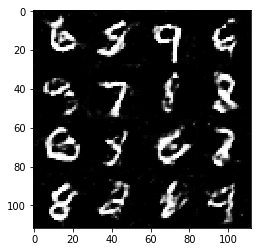

Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.4733... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.9978
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.8272


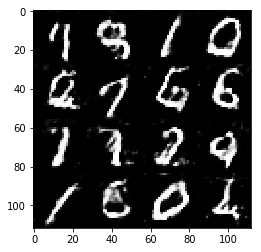

Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.8315


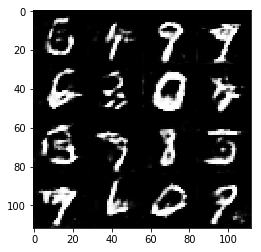

Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.9423
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 1.8872
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.9219
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.1408
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.5914... Generator Loss: 0.3607


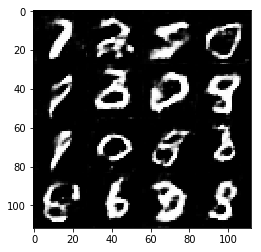

Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 1.8142
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 1.4234
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.4753
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.3018


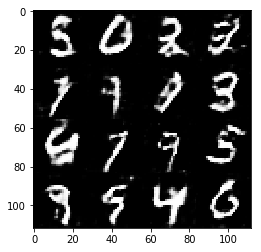

Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 1.2429
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.7749
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.5339


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 2.1729... Generator Loss: 1.7376
Epoch 1/5... Discriminator Loss: 1.1525... Generator Loss: 0.8426
Epoch 1/5... Discriminator Loss: 1.3263... Generator Loss: 0.9585
Epoch 1/5... Discriminator Loss: 1.8258... Generator Loss: 2.6197
Epoch 1/5... Discriminator Loss: 0.9418... Generator Loss: 2.4568
Epoch 1/5... Discriminator Loss: 1.2037... Generator Loss: 0.8456
Epoch 1/5... Discriminator Loss: 0.9265... Generator Loss: 1.5259
Epoch 1/5... Discriminator Loss: 1.4046... Generator Loss: 1.1214
Epoch 1/5... Discriminator Loss: 2.5865... Generator Loss: 2.4155
Epoch 1/5... Discriminator Loss: 1.5061... Generator Loss: 0.5612


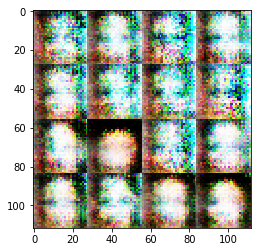

Epoch 1/5... Discriminator Loss: 1.3686... Generator Loss: 0.8229
Epoch 1/5... Discriminator Loss: 1.5462... Generator Loss: 0.7233
Epoch 1/5... Discriminator Loss: 1.3462... Generator Loss: 1.1231
Epoch 1/5... Discriminator Loss: 1.6648... Generator Loss: 0.3756
Epoch 1/5... Discriminator Loss: 1.3218... Generator Loss: 0.9640
Epoch 1/5... Discriminator Loss: 1.7715... Generator Loss: 0.3969
Epoch 1/5... Discriminator Loss: 1.4521... Generator Loss: 1.6965
Epoch 1/5... Discriminator Loss: 1.2821... Generator Loss: 1.0752
Epoch 1/5... Discriminator Loss: 1.2216... Generator Loss: 0.9871
Epoch 1/5... Discriminator Loss: 1.3955... Generator Loss: 1.1838


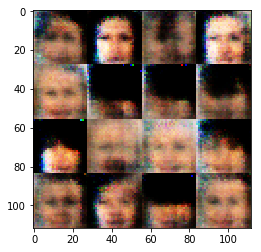

Epoch 1/5... Discriminator Loss: 1.7276... Generator Loss: 1.1190
Epoch 1/5... Discriminator Loss: 1.6454... Generator Loss: 0.4655
Epoch 1/5... Discriminator Loss: 1.6953... Generator Loss: 0.7434
Epoch 1/5... Discriminator Loss: 1.5607... Generator Loss: 0.7320
Epoch 1/5... Discriminator Loss: 1.3302... Generator Loss: 0.7207
Epoch 1/5... Discriminator Loss: 1.6086... Generator Loss: 1.5516
Epoch 1/5... Discriminator Loss: 1.2596... Generator Loss: 0.7416
Epoch 1/5... Discriminator Loss: 1.2273... Generator Loss: 0.9905
Epoch 1/5... Discriminator Loss: 1.5379... Generator Loss: 0.5362
Epoch 1/5... Discriminator Loss: 1.3322... Generator Loss: 0.9792


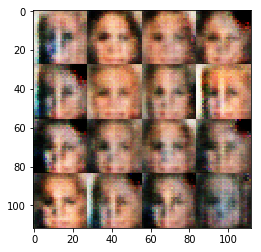

Epoch 1/5... Discriminator Loss: 1.3599... Generator Loss: 0.8086
Epoch 1/5... Discriminator Loss: 1.5900... Generator Loss: 1.6937
Epoch 1/5... Discriminator Loss: 1.3994... Generator Loss: 0.7689
Epoch 1/5... Discriminator Loss: 1.6694... Generator Loss: 0.5155
Epoch 1/5... Discriminator Loss: 1.3524... Generator Loss: 0.9733
Epoch 1/5... Discriminator Loss: 1.3754... Generator Loss: 0.8764
Epoch 1/5... Discriminator Loss: 1.3269... Generator Loss: 0.9296
Epoch 1/5... Discriminator Loss: 1.3331... Generator Loss: 0.8677
Epoch 1/5... Discriminator Loss: 1.3604... Generator Loss: 1.0477
Epoch 1/5... Discriminator Loss: 1.4024... Generator Loss: 0.8305


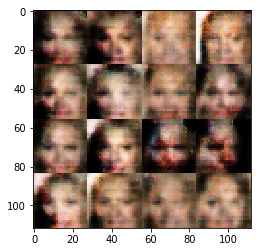

Epoch 1/5... Discriminator Loss: 1.3297... Generator Loss: 1.1337
Epoch 1/5... Discriminator Loss: 1.4752... Generator Loss: 0.5247
Epoch 1/5... Discriminator Loss: 1.9099... Generator Loss: 0.4899
Epoch 1/5... Discriminator Loss: 1.4153... Generator Loss: 0.6361
Epoch 1/5... Discriminator Loss: 1.4455... Generator Loss: 0.6474
Epoch 1/5... Discriminator Loss: 1.4112... Generator Loss: 0.9318
Epoch 1/5... Discriminator Loss: 1.3776... Generator Loss: 0.6867
Epoch 1/5... Discriminator Loss: 1.4301... Generator Loss: 0.8236
Epoch 1/5... Discriminator Loss: 1.2029... Generator Loss: 0.9787
Epoch 1/5... Discriminator Loss: 1.4557... Generator Loss: 0.6798


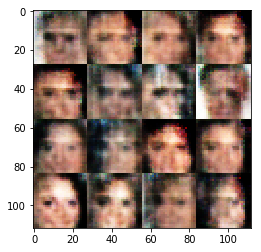

Epoch 1/5... Discriminator Loss: 1.4901... Generator Loss: 0.8788
Epoch 1/5... Discriminator Loss: 1.5096... Generator Loss: 0.7065
Epoch 1/5... Discriminator Loss: 1.3780... Generator Loss: 0.8330
Epoch 1/5... Discriminator Loss: 1.3550... Generator Loss: 0.7868
Epoch 1/5... Discriminator Loss: 1.4658... Generator Loss: 0.8315
Epoch 1/5... Discriminator Loss: 1.4376... Generator Loss: 0.5828
Epoch 1/5... Discriminator Loss: 1.6482... Generator Loss: 0.6191
Epoch 1/5... Discriminator Loss: 1.4790... Generator Loss: 0.6905
Epoch 1/5... Discriminator Loss: 1.4125... Generator Loss: 0.9413
Epoch 1/5... Discriminator Loss: 1.4711... Generator Loss: 0.7356


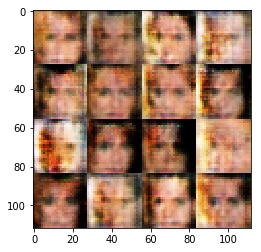

Epoch 1/5... Discriminator Loss: 1.3338... Generator Loss: 0.9724
Epoch 1/5... Discriminator Loss: 1.3019... Generator Loss: 0.7734
Epoch 1/5... Discriminator Loss: 1.3357... Generator Loss: 0.9474
Epoch 1/5... Discriminator Loss: 1.3871... Generator Loss: 0.6961
Epoch 1/5... Discriminator Loss: 1.3711... Generator Loss: 0.8115
Epoch 1/5... Discriminator Loss: 1.3936... Generator Loss: 0.7710
Epoch 1/5... Discriminator Loss: 1.5681... Generator Loss: 0.5293
Epoch 1/5... Discriminator Loss: 1.4062... Generator Loss: 0.7483
Epoch 1/5... Discriminator Loss: 1.4921... Generator Loss: 0.7493
Epoch 1/5... Discriminator Loss: 1.4319... Generator Loss: 0.8275


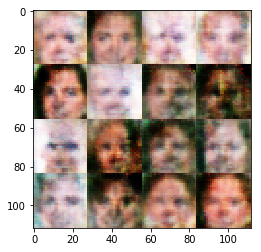

Epoch 1/5... Discriminator Loss: 1.4393... Generator Loss: 0.9687
Epoch 1/5... Discriminator Loss: 1.2409... Generator Loss: 1.0066
Epoch 1/5... Discriminator Loss: 1.3916... Generator Loss: 0.8718
Epoch 1/5... Discriminator Loss: 1.4202... Generator Loss: 0.9194
Epoch 1/5... Discriminator Loss: 1.3846... Generator Loss: 0.7907
Epoch 1/5... Discriminator Loss: 1.4117... Generator Loss: 0.9001
Epoch 1/5... Discriminator Loss: 1.4047... Generator Loss: 0.8553
Epoch 1/5... Discriminator Loss: 1.3730... Generator Loss: 0.7489
Epoch 1/5... Discriminator Loss: 1.4406... Generator Loss: 0.7686
Epoch 1/5... Discriminator Loss: 1.4182... Generator Loss: 0.8726


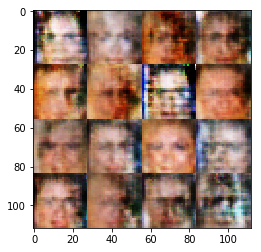

Epoch 1/5... Discriminator Loss: 1.3781... Generator Loss: 0.8069
Epoch 1/5... Discriminator Loss: 1.4324... Generator Loss: 0.9121
Epoch 1/5... Discriminator Loss: 1.3570... Generator Loss: 0.7860
Epoch 1/5... Discriminator Loss: 1.4409... Generator Loss: 0.9569
Epoch 1/5... Discriminator Loss: 1.4287... Generator Loss: 0.6964
Epoch 1/5... Discriminator Loss: 1.3817... Generator Loss: 0.8720
Epoch 1/5... Discriminator Loss: 1.2319... Generator Loss: 0.8686
Epoch 1/5... Discriminator Loss: 1.4752... Generator Loss: 0.8113
Epoch 1/5... Discriminator Loss: 1.4985... Generator Loss: 0.7487
Epoch 1/5... Discriminator Loss: 1.3663... Generator Loss: 0.8008


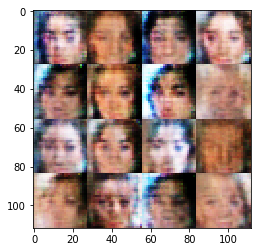

Epoch 1/5... Discriminator Loss: 1.4710... Generator Loss: 0.7229
Epoch 1/5... Discriminator Loss: 1.3519... Generator Loss: 0.7822
Epoch 1/5... Discriminator Loss: 1.3269... Generator Loss: 0.7715
Epoch 1/5... Discriminator Loss: 1.3967... Generator Loss: 0.8401
Epoch 1/5... Discriminator Loss: 1.4537... Generator Loss: 0.7437
Epoch 1/5... Discriminator Loss: 1.4375... Generator Loss: 0.7901
Epoch 1/5... Discriminator Loss: 1.4269... Generator Loss: 0.7627
Epoch 1/5... Discriminator Loss: 1.4745... Generator Loss: 0.8893
Epoch 1/5... Discriminator Loss: 1.4848... Generator Loss: 0.6185
Epoch 1/5... Discriminator Loss: 1.4407... Generator Loss: 0.7803


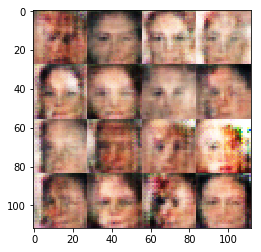

Epoch 1/5... Discriminator Loss: 1.3217... Generator Loss: 0.9122
Epoch 1/5... Discriminator Loss: 1.4762... Generator Loss: 0.7050
Epoch 1/5... Discriminator Loss: 1.4675... Generator Loss: 0.8764
Epoch 1/5... Discriminator Loss: 1.3982... Generator Loss: 0.7217
Epoch 1/5... Discriminator Loss: 1.3872... Generator Loss: 0.8240
Epoch 1/5... Discriminator Loss: 1.4268... Generator Loss: 0.7273
Epoch 1/5... Discriminator Loss: 1.5000... Generator Loss: 0.7900
Epoch 1/5... Discriminator Loss: 1.4147... Generator Loss: 0.7424
Epoch 1/5... Discriminator Loss: 1.3941... Generator Loss: 0.7655
Epoch 1/5... Discriminator Loss: 1.2826... Generator Loss: 0.8511


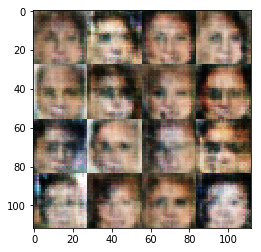

Epoch 1/5... Discriminator Loss: 1.3539... Generator Loss: 0.7649
Epoch 1/5... Discriminator Loss: 1.4059... Generator Loss: 0.7606
Epoch 1/5... Discriminator Loss: 1.3705... Generator Loss: 0.8140
Epoch 1/5... Discriminator Loss: 1.4225... Generator Loss: 0.8288
Epoch 1/5... Discriminator Loss: 1.3712... Generator Loss: 0.8237
Epoch 1/5... Discriminator Loss: 1.4506... Generator Loss: 0.7438
Epoch 1/5... Discriminator Loss: 1.4122... Generator Loss: 0.7804
Epoch 1/5... Discriminator Loss: 1.3809... Generator Loss: 0.8489
Epoch 1/5... Discriminator Loss: 1.3710... Generator Loss: 0.8331
Epoch 1/5... Discriminator Loss: 1.4638... Generator Loss: 0.6461


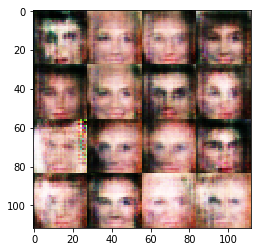

Epoch 1/5... Discriminator Loss: 1.4854... Generator Loss: 0.7726
Epoch 1/5... Discriminator Loss: 1.4170... Generator Loss: 0.7566
Epoch 1/5... Discriminator Loss: 1.3993... Generator Loss: 0.7221
Epoch 1/5... Discriminator Loss: 1.4156... Generator Loss: 0.7740
Epoch 1/5... Discriminator Loss: 1.4865... Generator Loss: 0.7523
Epoch 1/5... Discriminator Loss: 1.3161... Generator Loss: 0.8692
Epoch 1/5... Discriminator Loss: 1.4234... Generator Loss: 0.7450
Epoch 1/5... Discriminator Loss: 1.3116... Generator Loss: 0.8343
Epoch 1/5... Discriminator Loss: 1.5499... Generator Loss: 0.6881
Epoch 1/5... Discriminator Loss: 1.4490... Generator Loss: 0.7589


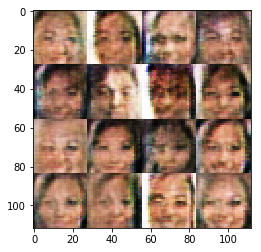

Epoch 1/5... Discriminator Loss: 1.3290... Generator Loss: 0.8274
Epoch 1/5... Discriminator Loss: 1.4729... Generator Loss: 0.7961
Epoch 1/5... Discriminator Loss: 1.4175... Generator Loss: 0.8684
Epoch 1/5... Discriminator Loss: 1.4068... Generator Loss: 0.7265
Epoch 1/5... Discriminator Loss: 1.4198... Generator Loss: 0.7671
Epoch 1/5... Discriminator Loss: 1.3406... Generator Loss: 0.7909
Epoch 1/5... Discriminator Loss: 1.4415... Generator Loss: 0.8138
Epoch 1/5... Discriminator Loss: 1.4221... Generator Loss: 0.7282
Epoch 1/5... Discriminator Loss: 1.4150... Generator Loss: 0.7547
Epoch 1/5... Discriminator Loss: 1.3877... Generator Loss: 0.7737


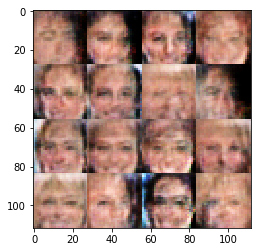

Epoch 1/5... Discriminator Loss: 1.3749... Generator Loss: 0.8489
Epoch 1/5... Discriminator Loss: 1.3721... Generator Loss: 0.7658
Epoch 1/5... Discriminator Loss: 1.5201... Generator Loss: 0.7671
Epoch 1/5... Discriminator Loss: 1.4010... Generator Loss: 0.7090
Epoch 1/5... Discriminator Loss: 1.4782... Generator Loss: 0.7726
Epoch 1/5... Discriminator Loss: 1.2894... Generator Loss: 0.8023
Epoch 1/5... Discriminator Loss: 1.4264... Generator Loss: 0.8068
Epoch 1/5... Discriminator Loss: 1.3825... Generator Loss: 0.7614
Epoch 1/5... Discriminator Loss: 1.4096... Generator Loss: 0.6716
Epoch 1/5... Discriminator Loss: 1.4018... Generator Loss: 0.7734


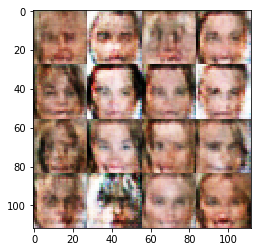

Epoch 1/5... Discriminator Loss: 1.3838... Generator Loss: 0.7738
Epoch 1/5... Discriminator Loss: 1.4004... Generator Loss: 0.7682
Epoch 1/5... Discriminator Loss: 1.4403... Generator Loss: 0.7720
Epoch 1/5... Discriminator Loss: 1.4429... Generator Loss: 0.7802
Epoch 1/5... Discriminator Loss: 1.3263... Generator Loss: 0.8399
Epoch 1/5... Discriminator Loss: 1.3693... Generator Loss: 0.7752
Epoch 1/5... Discriminator Loss: 1.4010... Generator Loss: 0.7994
Epoch 1/5... Discriminator Loss: 1.3766... Generator Loss: 0.7905
Epoch 1/5... Discriminator Loss: 1.4628... Generator Loss: 0.8422
Epoch 1/5... Discriminator Loss: 1.3603... Generator Loss: 0.8190


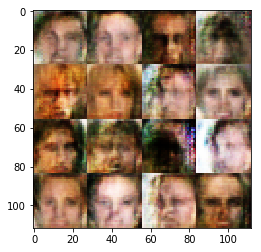

Epoch 1/5... Discriminator Loss: 1.3710... Generator Loss: 0.8697
Epoch 1/5... Discriminator Loss: 1.3697... Generator Loss: 0.8336
Epoch 1/5... Discriminator Loss: 1.4266... Generator Loss: 0.7207
Epoch 1/5... Discriminator Loss: 1.4638... Generator Loss: 0.6985
Epoch 1/5... Discriminator Loss: 1.3641... Generator Loss: 0.8453
Epoch 1/5... Discriminator Loss: 1.3590... Generator Loss: 0.7233
Epoch 1/5... Discriminator Loss: 1.3570... Generator Loss: 0.8560
Epoch 1/5... Discriminator Loss: 1.4113... Generator Loss: 0.7770
Epoch 1/5... Discriminator Loss: 1.4602... Generator Loss: 0.7798
Epoch 1/5... Discriminator Loss: 1.3611... Generator Loss: 0.7398


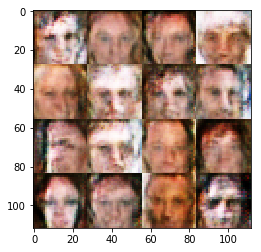

Epoch 1/5... Discriminator Loss: 1.4542... Generator Loss: 0.6745
Epoch 1/5... Discriminator Loss: 1.3779... Generator Loss: 0.8304
Epoch 1/5... Discriminator Loss: 1.3201... Generator Loss: 0.7638
Epoch 1/5... Discriminator Loss: 1.3892... Generator Loss: 0.8076
Epoch 1/5... Discriminator Loss: 1.4568... Generator Loss: 0.7485
Epoch 1/5... Discriminator Loss: 1.3334... Generator Loss: 0.7898
Epoch 1/5... Discriminator Loss: 1.3893... Generator Loss: 0.8334
Epoch 1/5... Discriminator Loss: 1.4024... Generator Loss: 0.8242
Epoch 1/5... Discriminator Loss: 1.4072... Generator Loss: 0.7386
Epoch 1/5... Discriminator Loss: 1.3754... Generator Loss: 0.8478


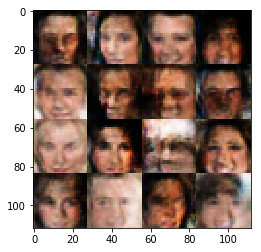

Epoch 1/5... Discriminator Loss: 1.3664... Generator Loss: 0.7559
Epoch 1/5... Discriminator Loss: 1.3483... Generator Loss: 0.8058
Epoch 1/5... Discriminator Loss: 1.4587... Generator Loss: 0.7662
Epoch 1/5... Discriminator Loss: 1.3560... Generator Loss: 0.8356
Epoch 1/5... Discriminator Loss: 1.3916... Generator Loss: 0.7711
Epoch 1/5... Discriminator Loss: 1.4094... Generator Loss: 0.8494
Epoch 1/5... Discriminator Loss: 1.3567... Generator Loss: 0.8269
Epoch 1/5... Discriminator Loss: 1.3788... Generator Loss: 0.8463
Epoch 1/5... Discriminator Loss: 1.4014... Generator Loss: 0.8273
Epoch 1/5... Discriminator Loss: 1.4334... Generator Loss: 0.6859


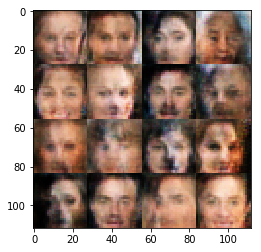

Epoch 1/5... Discriminator Loss: 1.4010... Generator Loss: 0.8271
Epoch 1/5... Discriminator Loss: 1.3503... Generator Loss: 0.8525
Epoch 1/5... Discriminator Loss: 1.3820... Generator Loss: 0.7891
Epoch 1/5... Discriminator Loss: 1.3247... Generator Loss: 0.8754
Epoch 1/5... Discriminator Loss: 1.4505... Generator Loss: 0.7642
Epoch 1/5... Discriminator Loss: 1.3490... Generator Loss: 0.8169
Epoch 1/5... Discriminator Loss: 1.4127... Generator Loss: 0.8194
Epoch 1/5... Discriminator Loss: 1.3832... Generator Loss: 0.7758
Epoch 1/5... Discriminator Loss: 1.3951... Generator Loss: 0.7570
Epoch 1/5... Discriminator Loss: 1.4104... Generator Loss: 0.8169


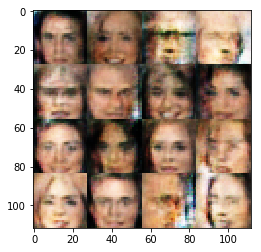

Epoch 1/5... Discriminator Loss: 1.4125... Generator Loss: 0.7931
Epoch 1/5... Discriminator Loss: 1.4180... Generator Loss: 0.7838
Epoch 1/5... Discriminator Loss: 1.3983... Generator Loss: 0.7771
Epoch 1/5... Discriminator Loss: 1.3772... Generator Loss: 0.8209
Epoch 1/5... Discriminator Loss: 1.4102... Generator Loss: 0.7343
Epoch 1/5... Discriminator Loss: 1.3950... Generator Loss: 0.8440
Epoch 1/5... Discriminator Loss: 1.3918... Generator Loss: 0.8221
Epoch 1/5... Discriminator Loss: 1.3818... Generator Loss: 0.7992
Epoch 1/5... Discriminator Loss: 1.3632... Generator Loss: 0.8099
Epoch 1/5... Discriminator Loss: 1.4208... Generator Loss: 0.7363


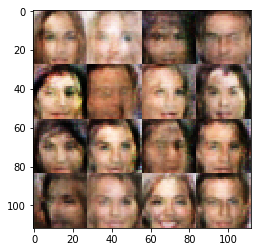

Epoch 1/5... Discriminator Loss: 1.3821... Generator Loss: 0.7759
Epoch 1/5... Discriminator Loss: 1.3384... Generator Loss: 0.7296
Epoch 1/5... Discriminator Loss: 1.3482... Generator Loss: 0.8277
Epoch 1/5... Discriminator Loss: 1.3570... Generator Loss: 0.8192
Epoch 1/5... Discriminator Loss: 1.4232... Generator Loss: 0.7494
Epoch 1/5... Discriminator Loss: 1.3789... Generator Loss: 0.8179
Epoch 1/5... Discriminator Loss: 1.3792... Generator Loss: 0.7613
Epoch 1/5... Discriminator Loss: 1.4143... Generator Loss: 0.7663
Epoch 1/5... Discriminator Loss: 1.3881... Generator Loss: 0.7571
Epoch 1/5... Discriminator Loss: 1.3408... Generator Loss: 0.8565


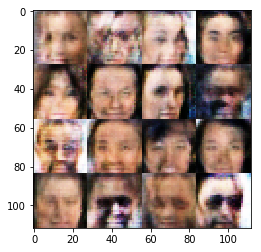

Epoch 1/5... Discriminator Loss: 1.4226... Generator Loss: 0.6885
Epoch 1/5... Discriminator Loss: 1.3448... Generator Loss: 0.7775
Epoch 1/5... Discriminator Loss: 1.4479... Generator Loss: 0.7717
Epoch 1/5... Discriminator Loss: 1.3181... Generator Loss: 0.8132
Epoch 1/5... Discriminator Loss: 1.3667... Generator Loss: 0.8000
Epoch 1/5... Discriminator Loss: 1.4112... Generator Loss: 0.7369
Epoch 1/5... Discriminator Loss: 1.3529... Generator Loss: 0.7970
Epoch 1/5... Discriminator Loss: 1.4333... Generator Loss: 0.8385
Epoch 1/5... Discriminator Loss: 1.3912... Generator Loss: 0.7859
Epoch 1/5... Discriminator Loss: 1.4566... Generator Loss: 0.7390


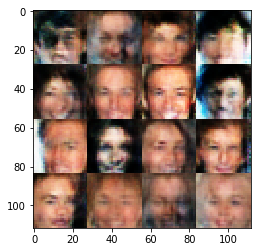

Epoch 1/5... Discriminator Loss: 1.3857... Generator Loss: 0.7900
Epoch 1/5... Discriminator Loss: 1.3727... Generator Loss: 0.7794
Epoch 1/5... Discriminator Loss: 1.3801... Generator Loss: 0.7380
Epoch 1/5... Discriminator Loss: 1.3781... Generator Loss: 0.7319
Epoch 1/5... Discriminator Loss: 1.3712... Generator Loss: 0.7973
Epoch 1/5... Discriminator Loss: 1.3712... Generator Loss: 0.8023
Epoch 1/5... Discriminator Loss: 1.3373... Generator Loss: 0.7681
Epoch 1/5... Discriminator Loss: 1.4479... Generator Loss: 0.7263
Epoch 1/5... Discriminator Loss: 1.3710... Generator Loss: 0.8256
Epoch 1/5... Discriminator Loss: 1.3740... Generator Loss: 0.7460


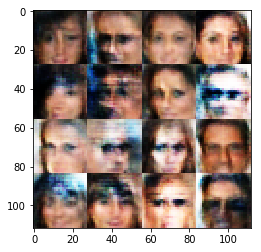

Epoch 1/5... Discriminator Loss: 1.3880... Generator Loss: 0.8210
Epoch 1/5... Discriminator Loss: 1.3772... Generator Loss: 0.7422
Epoch 1/5... Discriminator Loss: 1.4048... Generator Loss: 0.7481
Epoch 1/5... Discriminator Loss: 1.3945... Generator Loss: 0.8176
Epoch 1/5... Discriminator Loss: 1.4257... Generator Loss: 0.7719
Epoch 1/5... Discriminator Loss: 1.3740... Generator Loss: 0.7861
Epoch 1/5... Discriminator Loss: 1.4680... Generator Loss: 0.7372
Epoch 1/5... Discriminator Loss: 1.3639... Generator Loss: 0.8956
Epoch 1/5... Discriminator Loss: 1.3589... Generator Loss: 0.8010
Epoch 1/5... Discriminator Loss: 1.3798... Generator Loss: 0.7674


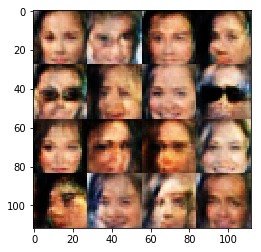

Epoch 1/5... Discriminator Loss: 1.3211... Generator Loss: 0.8096
Epoch 1/5... Discriminator Loss: 1.4224... Generator Loss: 0.7832
Epoch 1/5... Discriminator Loss: 1.3613... Generator Loss: 0.7751
Epoch 1/5... Discriminator Loss: 1.3958... Generator Loss: 0.8236
Epoch 1/5... Discriminator Loss: 1.3766... Generator Loss: 0.7749
Epoch 1/5... Discriminator Loss: 1.3819... Generator Loss: 0.7524
Epoch 1/5... Discriminator Loss: 1.3944... Generator Loss: 0.8714
Epoch 1/5... Discriminator Loss: 1.3704... Generator Loss: 0.7633
Epoch 1/5... Discriminator Loss: 1.3813... Generator Loss: 0.7700
Epoch 1/5... Discriminator Loss: 1.4363... Generator Loss: 0.7377


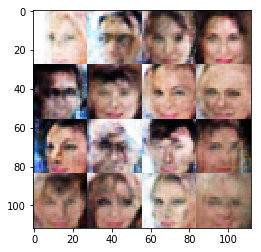

Epoch 1/5... Discriminator Loss: 1.4393... Generator Loss: 0.7097
Epoch 1/5... Discriminator Loss: 1.4050... Generator Loss: 0.7603
Epoch 1/5... Discriminator Loss: 1.3556... Generator Loss: 0.8098
Epoch 1/5... Discriminator Loss: 1.3564... Generator Loss: 0.7774
Epoch 1/5... Discriminator Loss: 1.4100... Generator Loss: 0.7933
Epoch 1/5... Discriminator Loss: 1.4458... Generator Loss: 0.7764
Epoch 1/5... Discriminator Loss: 1.3890... Generator Loss: 0.7849
Epoch 1/5... Discriminator Loss: 1.3921... Generator Loss: 0.7722
Epoch 1/5... Discriminator Loss: 1.4618... Generator Loss: 0.7562
Epoch 1/5... Discriminator Loss: 1.5211... Generator Loss: 0.6414


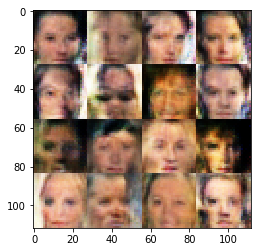

Epoch 1/5... Discriminator Loss: 1.3580... Generator Loss: 0.7583
Epoch 1/5... Discriminator Loss: 1.3634... Generator Loss: 0.7957
Epoch 1/5... Discriminator Loss: 1.4153... Generator Loss: 0.7829
Epoch 1/5... Discriminator Loss: 1.4267... Generator Loss: 0.7873
Epoch 1/5... Discriminator Loss: 1.4079... Generator Loss: 0.8179
Epoch 1/5... Discriminator Loss: 1.3811... Generator Loss: 0.7767
Epoch 1/5... Discriminator Loss: 1.3708... Generator Loss: 0.7719
Epoch 1/5... Discriminator Loss: 1.3731... Generator Loss: 0.7634
Epoch 1/5... Discriminator Loss: 1.3916... Generator Loss: 0.7666
Epoch 1/5... Discriminator Loss: 1.3551... Generator Loss: 0.8089


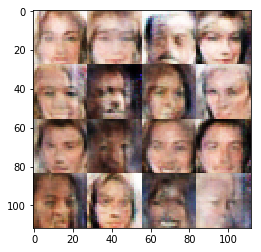

Epoch 1/5... Discriminator Loss: 1.3888... Generator Loss: 0.7664
Epoch 1/5... Discriminator Loss: 1.4046... Generator Loss: 0.8224
Epoch 1/5... Discriminator Loss: 1.3830... Generator Loss: 0.7989
Epoch 1/5... Discriminator Loss: 1.3713... Generator Loss: 0.7755
Epoch 1/5... Discriminator Loss: 1.4011... Generator Loss: 0.6969
Epoch 1/5... Discriminator Loss: 1.3391... Generator Loss: 0.8055
Epoch 1/5... Discriminator Loss: 1.4134... Generator Loss: 0.7903
Epoch 1/5... Discriminator Loss: 1.4027... Generator Loss: 0.7370
Epoch 1/5... Discriminator Loss: 1.3558... Generator Loss: 0.7791
Epoch 1/5... Discriminator Loss: 1.3483... Generator Loss: 0.7683


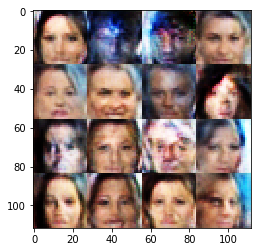

Epoch 1/5... Discriminator Loss: 1.3568... Generator Loss: 0.8469
Epoch 1/5... Discriminator Loss: 1.4073... Generator Loss: 0.8112
Epoch 1/5... Discriminator Loss: 1.3557... Generator Loss: 0.7969
Epoch 1/5... Discriminator Loss: 1.4241... Generator Loss: 0.7881
Epoch 1/5... Discriminator Loss: 1.4238... Generator Loss: 0.9276
Epoch 1/5... Discriminator Loss: 1.3526... Generator Loss: 0.8295
Epoch 1/5... Discriminator Loss: 1.3459... Generator Loss: 0.8176
Epoch 1/5... Discriminator Loss: 1.4193... Generator Loss: 0.7578
Epoch 1/5... Discriminator Loss: 1.3764... Generator Loss: 0.7551
Epoch 1/5... Discriminator Loss: 1.4086... Generator Loss: 0.7501


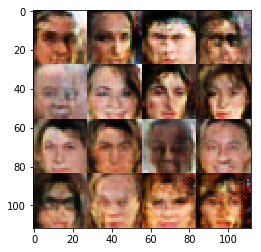

Epoch 1/5... Discriminator Loss: 1.3212... Generator Loss: 0.8211
Epoch 1/5... Discriminator Loss: 1.3768... Generator Loss: 0.8153
Epoch 1/5... Discriminator Loss: 1.3831... Generator Loss: 0.8345
Epoch 1/5... Discriminator Loss: 1.3386... Generator Loss: 0.8355
Epoch 1/5... Discriminator Loss: 1.3564... Generator Loss: 0.8030
Epoch 1/5... Discriminator Loss: 1.4185... Generator Loss: 0.7974
Epoch 1/5... Discriminator Loss: 1.3711... Generator Loss: 0.7632
Epoch 1/5... Discriminator Loss: 1.4289... Generator Loss: 0.7046
Epoch 1/5... Discriminator Loss: 1.3781... Generator Loss: 0.7896
Epoch 1/5... Discriminator Loss: 1.3175... Generator Loss: 0.8941


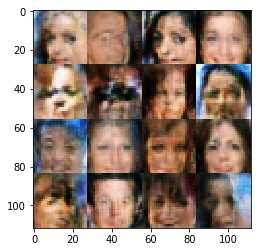

Epoch 1/5... Discriminator Loss: 1.3501... Generator Loss: 0.8668
Epoch 1/5... Discriminator Loss: 1.4020... Generator Loss: 0.7749
Epoch 1/5... Discriminator Loss: 1.3950... Generator Loss: 0.8058
Epoch 1/5... Discriminator Loss: 1.4619... Generator Loss: 0.8112
Epoch 1/5... Discriminator Loss: 1.4196... Generator Loss: 0.8410
Epoch 1/5... Discriminator Loss: 1.3826... Generator Loss: 0.7768
Epoch 2/5... Discriminator Loss: 1.3735... Generator Loss: 0.7871
Epoch 2/5... Discriminator Loss: 1.3533... Generator Loss: 0.8165
Epoch 2/5... Discriminator Loss: 1.4202... Generator Loss: 0.7220
Epoch 2/5... Discriminator Loss: 1.3742... Generator Loss: 0.7601


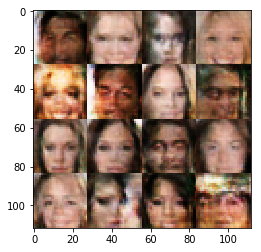

Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.7699
Epoch 2/5... Discriminator Loss: 1.4298... Generator Loss: 0.8253
Epoch 2/5... Discriminator Loss: 1.3778... Generator Loss: 0.7824
Epoch 2/5... Discriminator Loss: 1.3701... Generator Loss: 0.8579
Epoch 2/5... Discriminator Loss: 1.3263... Generator Loss: 0.8169
Epoch 2/5... Discriminator Loss: 1.3661... Generator Loss: 0.8050
Epoch 2/5... Discriminator Loss: 1.3835... Generator Loss: 0.7494
Epoch 2/5... Discriminator Loss: 1.4157... Generator Loss: 0.7908
Epoch 2/5... Discriminator Loss: 1.3541... Generator Loss: 0.8457
Epoch 2/5... Discriminator Loss: 1.3814... Generator Loss: 0.8979


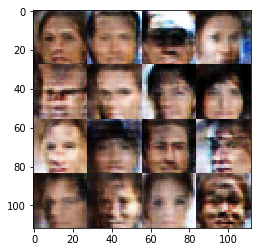

Epoch 2/5... Discriminator Loss: 1.3565... Generator Loss: 0.8062
Epoch 2/5... Discriminator Loss: 1.3965... Generator Loss: 0.7333
Epoch 2/5... Discriminator Loss: 1.3767... Generator Loss: 0.7628
Epoch 2/5... Discriminator Loss: 1.3621... Generator Loss: 0.8502
Epoch 2/5... Discriminator Loss: 1.3564... Generator Loss: 0.7631
Epoch 2/5... Discriminator Loss: 1.3941... Generator Loss: 0.8099
Epoch 2/5... Discriminator Loss: 1.3659... Generator Loss: 0.7819
Epoch 2/5... Discriminator Loss: 1.3512... Generator Loss: 0.8530
Epoch 2/5... Discriminator Loss: 1.3519... Generator Loss: 0.8288
Epoch 2/5... Discriminator Loss: 1.3954... Generator Loss: 0.7707


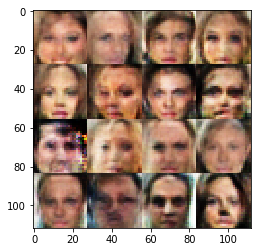

Epoch 2/5... Discriminator Loss: 1.3444... Generator Loss: 0.7850
Epoch 2/5... Discriminator Loss: 1.3733... Generator Loss: 0.8771
Epoch 2/5... Discriminator Loss: 1.4079... Generator Loss: 0.7473
Epoch 2/5... Discriminator Loss: 1.3526... Generator Loss: 0.7580
Epoch 2/5... Discriminator Loss: 1.3648... Generator Loss: 0.8295
Epoch 2/5... Discriminator Loss: 1.3400... Generator Loss: 0.8107
Epoch 2/5... Discriminator Loss: 1.3621... Generator Loss: 0.8897
Epoch 2/5... Discriminator Loss: 1.4038... Generator Loss: 0.7151
Epoch 2/5... Discriminator Loss: 1.3598... Generator Loss: 0.7976
Epoch 2/5... Discriminator Loss: 1.3826... Generator Loss: 0.7161


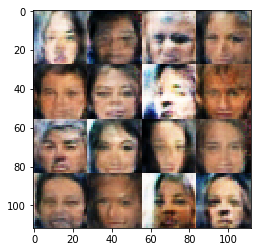

Epoch 2/5... Discriminator Loss: 1.3714... Generator Loss: 0.7991
Epoch 2/5... Discriminator Loss: 1.3918... Generator Loss: 0.8002
Epoch 2/5... Discriminator Loss: 1.4303... Generator Loss: 0.8019
Epoch 2/5... Discriminator Loss: 1.3813... Generator Loss: 0.8642
Epoch 2/5... Discriminator Loss: 1.3692... Generator Loss: 0.7484
Epoch 2/5... Discriminator Loss: 1.3957... Generator Loss: 0.7759
Epoch 2/5... Discriminator Loss: 1.3542... Generator Loss: 0.8171
Epoch 2/5... Discriminator Loss: 1.3797... Generator Loss: 0.7913
Epoch 2/5... Discriminator Loss: 1.3474... Generator Loss: 0.7709
Epoch 2/5... Discriminator Loss: 1.3810... Generator Loss: 0.7974


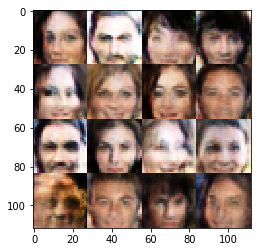

Epoch 2/5... Discriminator Loss: 1.3682... Generator Loss: 0.8194
Epoch 2/5... Discriminator Loss: 1.3833... Generator Loss: 0.7675
Epoch 2/5... Discriminator Loss: 1.3640... Generator Loss: 0.8188
Epoch 2/5... Discriminator Loss: 1.3953... Generator Loss: 0.7615
Epoch 2/5... Discriminator Loss: 1.3618... Generator Loss: 0.8144
Epoch 2/5... Discriminator Loss: 1.4033... Generator Loss: 0.8091
Epoch 2/5... Discriminator Loss: 1.3715... Generator Loss: 0.7731
Epoch 2/5... Discriminator Loss: 1.4164... Generator Loss: 0.7186
Epoch 2/5... Discriminator Loss: 1.4119... Generator Loss: 0.7459
Epoch 2/5... Discriminator Loss: 1.3860... Generator Loss: 0.8999


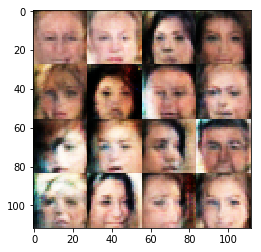

Epoch 2/5... Discriminator Loss: 1.4560... Generator Loss: 0.7540
Epoch 2/5... Discriminator Loss: 1.3856... Generator Loss: 0.7826
Epoch 2/5... Discriminator Loss: 1.3727... Generator Loss: 0.8128
Epoch 2/5... Discriminator Loss: 1.3917... Generator Loss: 0.8470
Epoch 2/5... Discriminator Loss: 1.3130... Generator Loss: 0.7958
Epoch 2/5... Discriminator Loss: 1.3558... Generator Loss: 0.7437
Epoch 2/5... Discriminator Loss: 1.3343... Generator Loss: 0.8261
Epoch 2/5... Discriminator Loss: 1.3835... Generator Loss: 0.8690
Epoch 2/5... Discriminator Loss: 1.3615... Generator Loss: 0.7442
Epoch 2/5... Discriminator Loss: 1.3767... Generator Loss: 0.7869


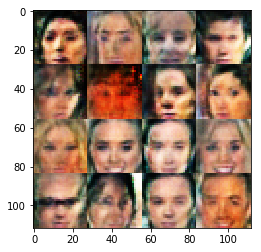

Epoch 2/5... Discriminator Loss: 1.4111... Generator Loss: 0.7919
Epoch 2/5... Discriminator Loss: 1.3677... Generator Loss: 0.7988
Epoch 2/5... Discriminator Loss: 1.3817... Generator Loss: 0.7854
Epoch 2/5... Discriminator Loss: 1.3327... Generator Loss: 0.8150
Epoch 2/5... Discriminator Loss: 1.3984... Generator Loss: 0.8537
Epoch 2/5... Discriminator Loss: 1.3597... Generator Loss: 0.8344
Epoch 2/5... Discriminator Loss: 1.3994... Generator Loss: 0.8112
Epoch 2/5... Discriminator Loss: 1.3206... Generator Loss: 0.7937
Epoch 2/5... Discriminator Loss: 1.4230... Generator Loss: 0.8040
Epoch 2/5... Discriminator Loss: 1.3479... Generator Loss: 0.8478


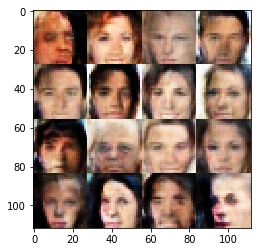

Epoch 2/5... Discriminator Loss: 1.3853... Generator Loss: 0.7766
Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.7957
Epoch 2/5... Discriminator Loss: 1.3682... Generator Loss: 0.7795
Epoch 2/5... Discriminator Loss: 1.3920... Generator Loss: 0.7766
Epoch 2/5... Discriminator Loss: 1.3911... Generator Loss: 0.8075
Epoch 2/5... Discriminator Loss: 1.3625... Generator Loss: 0.7808
Epoch 2/5... Discriminator Loss: 1.3634... Generator Loss: 0.8188
Epoch 2/5... Discriminator Loss: 1.3921... Generator Loss: 0.7998
Epoch 2/5... Discriminator Loss: 1.3628... Generator Loss: 0.8185
Epoch 2/5... Discriminator Loss: 1.4020... Generator Loss: 0.8601


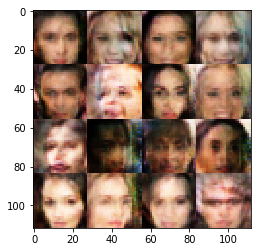

Epoch 2/5... Discriminator Loss: 1.3689... Generator Loss: 0.7707
Epoch 2/5... Discriminator Loss: 1.3953... Generator Loss: 0.7774
Epoch 2/5... Discriminator Loss: 1.3631... Generator Loss: 0.8021
Epoch 2/5... Discriminator Loss: 1.3999... Generator Loss: 0.8973
Epoch 2/5... Discriminator Loss: 1.3549... Generator Loss: 0.7816
Epoch 2/5... Discriminator Loss: 1.3692... Generator Loss: 0.7760
Epoch 2/5... Discriminator Loss: 1.3396... Generator Loss: 0.8156
Epoch 2/5... Discriminator Loss: 1.3491... Generator Loss: 0.7794
Epoch 2/5... Discriminator Loss: 1.4004... Generator Loss: 0.7856
Epoch 2/5... Discriminator Loss: 1.3988... Generator Loss: 0.8230


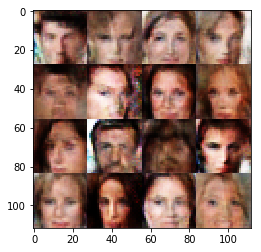

Epoch 2/5... Discriminator Loss: 1.3363... Generator Loss: 0.8280
Epoch 2/5... Discriminator Loss: 1.3947... Generator Loss: 0.7614
Epoch 2/5... Discriminator Loss: 1.3755... Generator Loss: 0.8147
Epoch 2/5... Discriminator Loss: 1.4131... Generator Loss: 0.7804
Epoch 2/5... Discriminator Loss: 1.3829... Generator Loss: 0.7560
Epoch 2/5... Discriminator Loss: 1.3344... Generator Loss: 0.8259
Epoch 2/5... Discriminator Loss: 1.3527... Generator Loss: 0.7906
Epoch 2/5... Discriminator Loss: 1.3819... Generator Loss: 0.8118
Epoch 2/5... Discriminator Loss: 1.3480... Generator Loss: 0.8336
Epoch 2/5... Discriminator Loss: 1.3622... Generator Loss: 0.7536


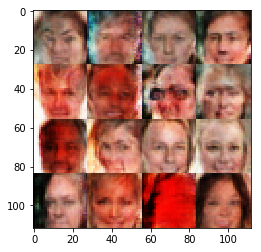

Epoch 2/5... Discriminator Loss: 1.3629... Generator Loss: 0.7735
Epoch 2/5... Discriminator Loss: 1.4013... Generator Loss: 0.7589
Epoch 2/5... Discriminator Loss: 1.3940... Generator Loss: 0.8152
Epoch 2/5... Discriminator Loss: 1.3814... Generator Loss: 0.8060
Epoch 2/5... Discriminator Loss: 1.4037... Generator Loss: 0.7164
Epoch 2/5... Discriminator Loss: 1.3622... Generator Loss: 0.7938
Epoch 2/5... Discriminator Loss: 1.3590... Generator Loss: 0.7790
Epoch 2/5... Discriminator Loss: 1.3891... Generator Loss: 0.8202
Epoch 2/5... Discriminator Loss: 1.3289... Generator Loss: 0.8364
Epoch 2/5... Discriminator Loss: 1.3809... Generator Loss: 0.8092


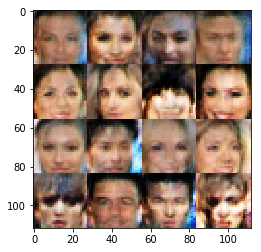

Epoch 2/5... Discriminator Loss: 1.4195... Generator Loss: 0.7473
Epoch 2/5... Discriminator Loss: 1.3697... Generator Loss: 0.7970
Epoch 2/5... Discriminator Loss: 1.3698... Generator Loss: 0.7844
Epoch 2/5... Discriminator Loss: 1.3915... Generator Loss: 0.8587
Epoch 2/5... Discriminator Loss: 1.3628... Generator Loss: 0.8321
Epoch 2/5... Discriminator Loss: 1.4109... Generator Loss: 0.7833
Epoch 2/5... Discriminator Loss: 1.3260... Generator Loss: 0.8166
Epoch 2/5... Discriminator Loss: 1.3824... Generator Loss: 0.8025
Epoch 2/5... Discriminator Loss: 1.3463... Generator Loss: 0.7783
Epoch 2/5... Discriminator Loss: 1.4117... Generator Loss: 0.7735


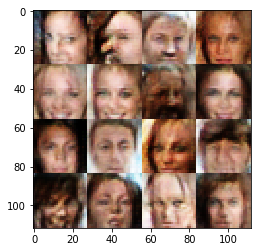

Epoch 2/5... Discriminator Loss: 1.3948... Generator Loss: 0.7963
Epoch 2/5... Discriminator Loss: 1.3623... Generator Loss: 0.7244
Epoch 2/5... Discriminator Loss: 1.3534... Generator Loss: 0.7698
Epoch 2/5... Discriminator Loss: 1.3848... Generator Loss: 0.7799
Epoch 2/5... Discriminator Loss: 1.3562... Generator Loss: 0.8437
Epoch 2/5... Discriminator Loss: 1.3255... Generator Loss: 0.7651
Epoch 2/5... Discriminator Loss: 1.4120... Generator Loss: 0.7965
Epoch 2/5... Discriminator Loss: 1.3454... Generator Loss: 0.8739
Epoch 2/5... Discriminator Loss: 1.3512... Generator Loss: 0.7687
Epoch 2/5... Discriminator Loss: 1.3846... Generator Loss: 0.7461


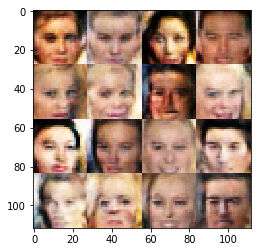

Epoch 2/5... Discriminator Loss: 1.3541... Generator Loss: 0.7876
Epoch 2/5... Discriminator Loss: 1.4065... Generator Loss: 0.7982
Epoch 2/5... Discriminator Loss: 1.3602... Generator Loss: 0.7629
Epoch 2/5... Discriminator Loss: 1.4232... Generator Loss: 0.8039
Epoch 2/5... Discriminator Loss: 1.3291... Generator Loss: 0.8273
Epoch 2/5... Discriminator Loss: 1.3415... Generator Loss: 0.7593
Epoch 2/5... Discriminator Loss: 1.3738... Generator Loss: 0.8126
Epoch 2/5... Discriminator Loss: 1.3889... Generator Loss: 0.8200
Epoch 2/5... Discriminator Loss: 1.3207... Generator Loss: 0.8482
Epoch 2/5... Discriminator Loss: 1.3994... Generator Loss: 0.8389


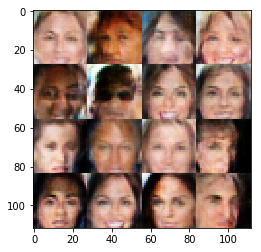

Epoch 2/5... Discriminator Loss: 1.3809... Generator Loss: 0.7235
Epoch 2/5... Discriminator Loss: 1.3916... Generator Loss: 0.7712
Epoch 2/5... Discriminator Loss: 1.3998... Generator Loss: 0.8104
Epoch 2/5... Discriminator Loss: 1.3795... Generator Loss: 0.7587
Epoch 2/5... Discriminator Loss: 1.3529... Generator Loss: 0.8176
Epoch 2/5... Discriminator Loss: 1.3839... Generator Loss: 0.8875
Epoch 2/5... Discriminator Loss: 1.3747... Generator Loss: 0.8463
Epoch 2/5... Discriminator Loss: 1.3916... Generator Loss: 0.7890
Epoch 2/5... Discriminator Loss: 1.3736... Generator Loss: 0.7463
Epoch 2/5... Discriminator Loss: 1.3637... Generator Loss: 0.7551


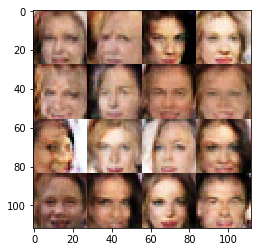

Epoch 2/5... Discriminator Loss: 1.4325... Generator Loss: 0.7061
Epoch 2/5... Discriminator Loss: 1.3385... Generator Loss: 0.8072
Epoch 2/5... Discriminator Loss: 1.3680... Generator Loss: 0.7826
Epoch 2/5... Discriminator Loss: 1.3764... Generator Loss: 0.8192
Epoch 2/5... Discriminator Loss: 1.3700... Generator Loss: 0.7726
Epoch 2/5... Discriminator Loss: 1.3267... Generator Loss: 0.8304
Epoch 2/5... Discriminator Loss: 1.3815... Generator Loss: 0.7393
Epoch 2/5... Discriminator Loss: 1.3641... Generator Loss: 0.8187
Epoch 2/5... Discriminator Loss: 1.4299... Generator Loss: 0.7385
Epoch 2/5... Discriminator Loss: 1.3290... Generator Loss: 0.8044


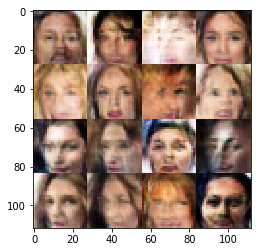

Epoch 2/5... Discriminator Loss: 1.3981... Generator Loss: 0.7264
Epoch 2/5... Discriminator Loss: 1.3652... Generator Loss: 0.8380
Epoch 2/5... Discriminator Loss: 1.3951... Generator Loss: 0.7096
Epoch 2/5... Discriminator Loss: 1.3921... Generator Loss: 0.8338
Epoch 2/5... Discriminator Loss: 1.3565... Generator Loss: 0.7902
Epoch 2/5... Discriminator Loss: 1.4312... Generator Loss: 0.7230
Epoch 2/5... Discriminator Loss: 1.4014... Generator Loss: 0.8276
Epoch 2/5... Discriminator Loss: 1.3755... Generator Loss: 0.7836
Epoch 2/5... Discriminator Loss: 1.4077... Generator Loss: 0.8187
Epoch 2/5... Discriminator Loss: 1.3069... Generator Loss: 0.7815


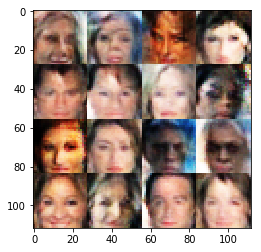

Epoch 2/5... Discriminator Loss: 1.3609... Generator Loss: 0.7891
Epoch 2/5... Discriminator Loss: 1.3940... Generator Loss: 0.8762
Epoch 2/5... Discriminator Loss: 1.3694... Generator Loss: 0.7108
Epoch 2/5... Discriminator Loss: 1.3843... Generator Loss: 0.7574
Epoch 2/5... Discriminator Loss: 1.3633... Generator Loss: 0.8154
Epoch 2/5... Discriminator Loss: 1.3281... Generator Loss: 0.8215
Epoch 2/5... Discriminator Loss: 1.3728... Generator Loss: 0.8218
Epoch 2/5... Discriminator Loss: 1.3589... Generator Loss: 0.7934
Epoch 2/5... Discriminator Loss: 1.3385... Generator Loss: 0.7955
Epoch 2/5... Discriminator Loss: 1.4011... Generator Loss: 0.7314


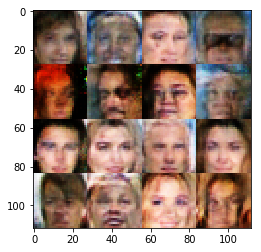

Epoch 2/5... Discriminator Loss: 1.3474... Generator Loss: 0.7802
Epoch 2/5... Discriminator Loss: 1.4077... Generator Loss: 0.8008
Epoch 2/5... Discriminator Loss: 1.3603... Generator Loss: 0.8172
Epoch 2/5... Discriminator Loss: 1.3456... Generator Loss: 0.7337
Epoch 2/5... Discriminator Loss: 1.3593... Generator Loss: 0.7979
Epoch 2/5... Discriminator Loss: 1.3213... Generator Loss: 0.7234
Epoch 2/5... Discriminator Loss: 1.3805... Generator Loss: 0.7988
Epoch 2/5... Discriminator Loss: 1.3446... Generator Loss: 0.8470
Epoch 2/5... Discriminator Loss: 1.3426... Generator Loss: 0.8384
Epoch 2/5... Discriminator Loss: 1.3121... Generator Loss: 0.8699


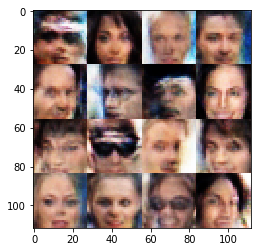

Epoch 2/5... Discriminator Loss: 1.4007... Generator Loss: 0.7528
Epoch 2/5... Discriminator Loss: 1.3442... Generator Loss: 0.8032
Epoch 2/5... Discriminator Loss: 1.3638... Generator Loss: 0.8645
Epoch 2/5... Discriminator Loss: 1.3219... Generator Loss: 0.8380
Epoch 2/5... Discriminator Loss: 1.3424... Generator Loss: 0.8138
Epoch 2/5... Discriminator Loss: 1.3377... Generator Loss: 0.8284
Epoch 2/5... Discriminator Loss: 1.3391... Generator Loss: 0.7559
Epoch 2/5... Discriminator Loss: 1.3563... Generator Loss: 0.7589
Epoch 2/5... Discriminator Loss: 1.3978... Generator Loss: 0.7545
Epoch 2/5... Discriminator Loss: 1.3586... Generator Loss: 0.7589


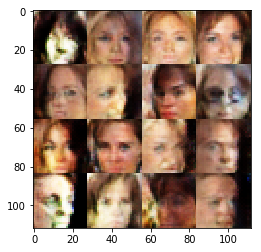

Epoch 2/5... Discriminator Loss: 1.3566... Generator Loss: 0.8148
Epoch 2/5... Discriminator Loss: 1.3173... Generator Loss: 0.7641
Epoch 2/5... Discriminator Loss: 1.4376... Generator Loss: 0.6809
Epoch 2/5... Discriminator Loss: 1.3779... Generator Loss: 0.7392
Epoch 2/5... Discriminator Loss: 1.3228... Generator Loss: 0.8106
Epoch 2/5... Discriminator Loss: 1.3998... Generator Loss: 0.7923
Epoch 2/5... Discriminator Loss: 1.3639... Generator Loss: 0.7645
Epoch 2/5... Discriminator Loss: 1.3604... Generator Loss: 0.7497
Epoch 2/5... Discriminator Loss: 1.3814... Generator Loss: 0.8078
Epoch 2/5... Discriminator Loss: 1.3838... Generator Loss: 0.7742


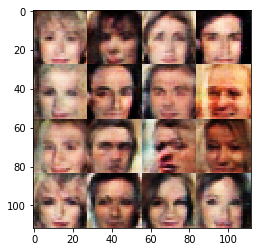

Epoch 2/5... Discriminator Loss: 1.3876... Generator Loss: 0.7292
Epoch 2/5... Discriminator Loss: 1.3588... Generator Loss: 0.7112
Epoch 2/5... Discriminator Loss: 1.3885... Generator Loss: 0.8026
Epoch 2/5... Discriminator Loss: 1.3399... Generator Loss: 0.7437
Epoch 2/5... Discriminator Loss: 1.4176... Generator Loss: 0.7928
Epoch 2/5... Discriminator Loss: 1.3951... Generator Loss: 0.7368
Epoch 2/5... Discriminator Loss: 1.3395... Generator Loss: 0.7840
Epoch 2/5... Discriminator Loss: 1.2933... Generator Loss: 0.7791
Epoch 2/5... Discriminator Loss: 1.3844... Generator Loss: 0.7675
Epoch 2/5... Discriminator Loss: 1.3133... Generator Loss: 0.8825


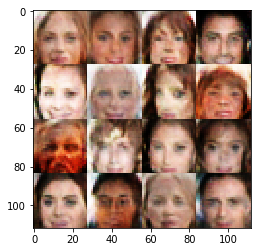

Epoch 2/5... Discriminator Loss: 1.3215... Generator Loss: 0.8158
Epoch 2/5... Discriminator Loss: 1.3721... Generator Loss: 0.7691
Epoch 2/5... Discriminator Loss: 1.3480... Generator Loss: 0.7961
Epoch 2/5... Discriminator Loss: 1.3962... Generator Loss: 0.8650
Epoch 2/5... Discriminator Loss: 1.3662... Generator Loss: 0.8152
Epoch 2/5... Discriminator Loss: 1.3740... Generator Loss: 0.8475
Epoch 2/5... Discriminator Loss: 1.3315... Generator Loss: 0.7562
Epoch 2/5... Discriminator Loss: 1.3563... Generator Loss: 0.7468
Epoch 2/5... Discriminator Loss: 1.3110... Generator Loss: 0.8168
Epoch 2/5... Discriminator Loss: 1.3320... Generator Loss: 0.8913


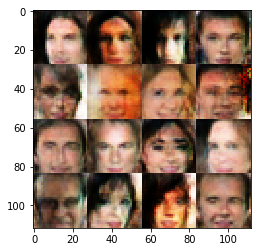

Epoch 2/5... Discriminator Loss: 1.3691... Generator Loss: 0.7757
Epoch 2/5... Discriminator Loss: 1.3338... Generator Loss: 0.8192
Epoch 2/5... Discriminator Loss: 1.4274... Generator Loss: 0.6482
Epoch 2/5... Discriminator Loss: 1.3841... Generator Loss: 0.7953
Epoch 2/5... Discriminator Loss: 1.2994... Generator Loss: 0.8388
Epoch 2/5... Discriminator Loss: 1.3059... Generator Loss: 0.8363
Epoch 2/5... Discriminator Loss: 1.2829... Generator Loss: 0.8576
Epoch 2/5... Discriminator Loss: 1.3126... Generator Loss: 0.7746
Epoch 2/5... Discriminator Loss: 1.3681... Generator Loss: 0.7765
Epoch 2/5... Discriminator Loss: 1.3575... Generator Loss: 0.7754


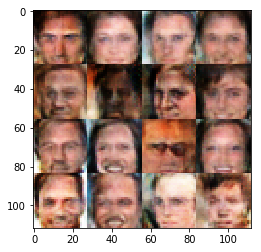

Epoch 2/5... Discriminator Loss: 1.3916... Generator Loss: 0.7310
Epoch 2/5... Discriminator Loss: 1.3301... Generator Loss: 0.8015
Epoch 2/5... Discriminator Loss: 1.3985... Generator Loss: 0.6962
Epoch 2/5... Discriminator Loss: 1.3942... Generator Loss: 0.7519
Epoch 2/5... Discriminator Loss: 1.3632... Generator Loss: 0.7028
Epoch 2/5... Discriminator Loss: 1.3984... Generator Loss: 0.7768
Epoch 2/5... Discriminator Loss: 1.2917... Generator Loss: 0.8689
Epoch 2/5... Discriminator Loss: 1.3597... Generator Loss: 0.8245
Epoch 2/5... Discriminator Loss: 1.3687... Generator Loss: 0.8185
Epoch 2/5... Discriminator Loss: 1.3596... Generator Loss: 0.8310


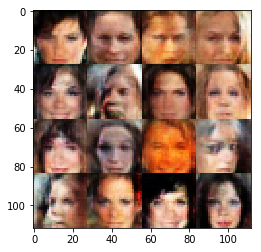

Epoch 2/5... Discriminator Loss: 1.3734... Generator Loss: 0.8859
Epoch 2/5... Discriminator Loss: 1.3671... Generator Loss: 0.7623
Epoch 2/5... Discriminator Loss: 1.3747... Generator Loss: 0.6846
Epoch 2/5... Discriminator Loss: 1.3475... Generator Loss: 0.7597
Epoch 2/5... Discriminator Loss: 1.3528... Generator Loss: 0.9040
Epoch 2/5... Discriminator Loss: 1.3789... Generator Loss: 0.7297
Epoch 2/5... Discriminator Loss: 1.3817... Generator Loss: 0.8327
Epoch 2/5... Discriminator Loss: 1.3019... Generator Loss: 0.8995
Epoch 2/5... Discriminator Loss: 1.4315... Generator Loss: 0.9489
Epoch 2/5... Discriminator Loss: 1.3608... Generator Loss: 0.8310


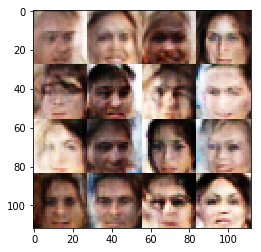

Epoch 2/5... Discriminator Loss: 1.3223... Generator Loss: 0.7916
Epoch 2/5... Discriminator Loss: 1.3300... Generator Loss: 0.8972
Epoch 2/5... Discriminator Loss: 1.3385... Generator Loss: 0.7866
Epoch 2/5... Discriminator Loss: 1.3222... Generator Loss: 0.8395
Epoch 2/5... Discriminator Loss: 1.3457... Generator Loss: 0.8208
Epoch 2/5... Discriminator Loss: 1.3171... Generator Loss: 0.8358
Epoch 2/5... Discriminator Loss: 1.3365... Generator Loss: 0.9364
Epoch 2/5... Discriminator Loss: 1.2945... Generator Loss: 0.7773
Epoch 2/5... Discriminator Loss: 1.3425... Generator Loss: 0.7056
Epoch 2/5... Discriminator Loss: 1.3241... Generator Loss: 0.7641


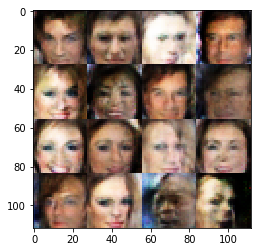

Epoch 2/5... Discriminator Loss: 1.3794... Generator Loss: 0.7044
Epoch 2/5... Discriminator Loss: 1.3878... Generator Loss: 0.8794
Epoch 2/5... Discriminator Loss: 1.3559... Generator Loss: 0.8220
Epoch 2/5... Discriminator Loss: 1.3197... Generator Loss: 0.7706
Epoch 2/5... Discriminator Loss: 1.4063... Generator Loss: 0.7784
Epoch 2/5... Discriminator Loss: 1.3699... Generator Loss: 0.8595
Epoch 2/5... Discriminator Loss: 1.2806... Generator Loss: 0.7564
Epoch 2/5... Discriminator Loss: 1.3160... Generator Loss: 0.7888
Epoch 2/5... Discriminator Loss: 1.3498... Generator Loss: 0.8304
Epoch 2/5... Discriminator Loss: 1.3865... Generator Loss: 0.7838


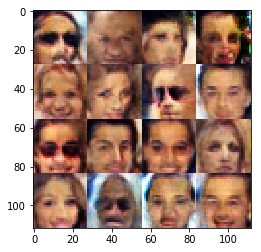

Epoch 2/5... Discriminator Loss: 1.3171... Generator Loss: 0.8094
Epoch 2/5... Discriminator Loss: 1.2970... Generator Loss: 0.7293
Epoch 2/5... Discriminator Loss: 1.3135... Generator Loss: 0.8977
Epoch 2/5... Discriminator Loss: 1.2762... Generator Loss: 0.8363
Epoch 2/5... Discriminator Loss: 1.3075... Generator Loss: 0.9148
Epoch 2/5... Discriminator Loss: 1.2778... Generator Loss: 0.8406
Epoch 2/5... Discriminator Loss: 1.3626... Generator Loss: 0.7880
Epoch 2/5... Discriminator Loss: 1.3269... Generator Loss: 0.8646
Epoch 2/5... Discriminator Loss: 1.3624... Generator Loss: 0.7607
Epoch 2/5... Discriminator Loss: 1.2742... Generator Loss: 0.8279
Epoch 2/5... Discriminator Loss: 1.2978... Generator Loss: 1.1452


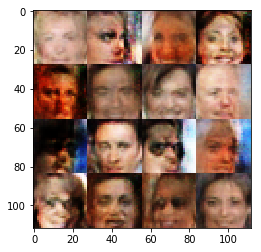

Epoch 2/5... Discriminator Loss: 1.4134... Generator Loss: 0.8652
Epoch 2/5... Discriminator Loss: 1.4068... Generator Loss: 0.8026
Epoch 2/5... Discriminator Loss: 1.3446... Generator Loss: 0.7156
Epoch 3/5... Discriminator Loss: 1.2520... Generator Loss: 0.9619
Epoch 3/5... Discriminator Loss: 1.2467... Generator Loss: 0.6861
Epoch 3/5... Discriminator Loss: 1.2241... Generator Loss: 0.8832
Epoch 3/5... Discriminator Loss: 1.3353... Generator Loss: 0.8854
Epoch 3/5... Discriminator Loss: 1.3154... Generator Loss: 0.8759
Epoch 3/5... Discriminator Loss: 1.3306... Generator Loss: 0.7864
Epoch 3/5... Discriminator Loss: 1.3307... Generator Loss: 0.6455


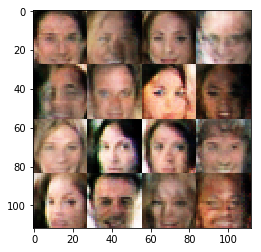

Epoch 3/5... Discriminator Loss: 1.3052... Generator Loss: 0.8609
Epoch 3/5... Discriminator Loss: 1.3110... Generator Loss: 0.6772
Epoch 3/5... Discriminator Loss: 1.3383... Generator Loss: 0.8797
Epoch 3/5... Discriminator Loss: 1.2967... Generator Loss: 0.7987
Epoch 3/5... Discriminator Loss: 1.3166... Generator Loss: 0.9886
Epoch 3/5... Discriminator Loss: 1.2789... Generator Loss: 0.8793
Epoch 3/5... Discriminator Loss: 1.3585... Generator Loss: 0.8075
Epoch 3/5... Discriminator Loss: 1.2347... Generator Loss: 0.7959
Epoch 3/5... Discriminator Loss: 1.3422... Generator Loss: 0.7209
Epoch 3/5... Discriminator Loss: 1.3719... Generator Loss: 0.7610


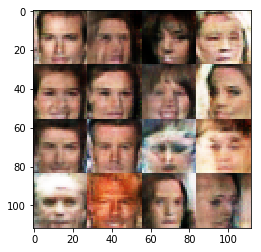

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.